In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random

In [4]:
def create_k_nearest_neighbors_graph(num_nodes, k, radius=10, polym='chain'):
    # Generate random positions for nodes in a 2D unit square
    positions = {i: (np.random.uniform(0, 1), np.random.uniform(0, 1)) for i in range(num_nodes)}
    
    # Create a graph where each node connects to its k nearest neighbors
    G = nx.Graph()
    G.add_nodes_from(positions.keys())
    nx.set_node_attributes(G, positions, "pos")
    
    if polym == 'step':
        node_func = [random.choice(['A','B']) for x in range(G.number_of_nodes())]
        nx.set_node_attributes(G, dict(zip(range(len(node_func)),node_func)), "func")
        
    # Calculate the Euclidean distance between nodes
    ki = 0
    for node1, pos1 in positions.items():
        distances = []
        for node2, pos2 in positions.items():
            if node1 != node2:
                dist = np.linalg.norm(np.array(pos1) - np.array(pos2))
                if polym == 'step':
                    distances.append((dist, node2, G.nodes[node2]['func']))
                else:
                    distances.append((dist, node2))

        # Sort by distance and connect to the k nearest neighbors
        distances.sort()  # Sort by distance

        if len(distances) > 0:
            neighbor_limit = np.where([distances[x][0]>radius for x in range(len(distances))])[0]
            if len(neighbor_limit)>0:
                if neighbor_limit[0]>0:
                    distances = distances[:neighbor_limit[0]]

            if polym == 'step':
                if G.nodes[node1]['func']=='A':
                    distances = [distances[x] for x in np.where(np.array(distances)[:,2]=='B')[0]]
                else:
                    distances = [distances[x] for x in np.where(np.array(distances)[:,2]=='A')[0]]

            if(len(neighbor_limit)==0):
                neighbor_limit = k[ki]
            else:
                neighbor_limit = min(neighbor_limit[0],k[ki])

            if polym == 'step':
                for _, neighbor, _ in distances[:neighbor_limit]:
                    G.add_edge(node1, neighbor)
            else:
                for _, neighbor in distances[:neighbor_limit]:
                    G.add_edge(node1, neighbor)
        ki = ki+1
    return G, positions

In [406]:
def prune_edges_to_x_degree(G, k, distribution='uniform'):
    """
    Prune edges from the graph so that no node has more than x edges.

    Parameters:
    - G: A NetworkX graph.
    - x: Maximum number of edges each node should have.
    - distribution: can be either 'uniform' for polymer with fixed functionalization degree or 'poisson' for unfixed

    Returns:
    - A modified graph with pruned edges.
    """
    G = G.copy()  # Create a copy to avoid modifying the original graph

    
    if(distribution == 'uniform'):
        # Iterate over nodes and prune edges if the degree exceeds x
        ki = 0
        for node in list(G.nodes()):
            while G.degree(node) > k[ki]:
                # Randomly remove one of the edges
                edge_to_remove = random.choice(list(G.edges(node)))
                G.remove_edge(*edge_to_remove)
        ki = ki + 1
    else:
        actual_k = [d for n, d in G.degree()]
        if(sum(k) < sum(actual_k)):
            edges_to_remove = random.sample(G.edges(), int(np.diff([sum(k), sum(actual_k)])/2))
            G.remove_edges_from(edges_to_remove)
        
    isolated_nodes = list(nx.isolates(G))

    # Remove isolated nodes
    G.remove_nodes_from(isolated_nodes)
    
    comps = sorted(nx.connected_components(G), key=len, reverse=False)
    if len(comps) > 1:
        node_list = [list(x) for x in comps[:-1]]
        node_list = [x for xs in node_list for x in xs]
        G.remove_nodes_from(node_list)
    
    return G

In [323]:
n_norbornene = 2500
fs = [4, 8, 18, 40]
n_nodes = [int(x) for x in n_norbornene/np.array(fs)]
ks = [[fs[0] for x in range(n_nodes[0])], np.random.poisson(fs[1],n_nodes[1]), 
      np.random.poisson(fs[2],n_nodes[2]), np.random.poisson(fs[3],n_nodes[3])]
dists = ['uniform','poisson','poisson','poisson']
radii = [.06, .12, .24, 0.6]#to simulate increasing length of polymers

In [324]:
Gs = []
Ps = []
Ts = []
for i in range(len(n_nodes)):
    # Create the graph
    G, positions = create_k_nearest_neighbors_graph(n_nodes[i], ks[i], radius=radii[i])
    # Randomly remove edges so that degree distribution approaches theoretical
    G_pruned = prune_edges_to_x_degree(G, ks[i], dists[i])
    # Compute minimum spanning tree (MST) as empirical calculation of critical gelation
    T = nx.minimum_spanning_tree(G_pruned)
    
    Ps.append(positions)
    Gs.append(G_pruned)
    Ts.append(T)

/tmp/ipykernel_203112/1373745447.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  edges_to_remove = random.sample(G.edges(), int(np.diff([sum(k), sum(actual_k)])/2))
/tmp/ipykernel_203112/1373745447.py:28: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  edges_to_remove = random.sample(G.edges(), int(np.diff([sum(k), sum(actual_k)])/2))


In [42]:
# Check that there are no unconnected nodes
[nx.is_connected(g) for g in Gs]

[True, True, True, True]

In [407]:
[g.number_of_edges() for g in Gs]

[1088, 1233, 1212, 1200]

In [408]:
[g.number_of_edges() for g in Ts]

[620, 311, 137, 61]

In [97]:
Ps = [nx.spring_layout(g) for g in Gs]

In [409]:
# Empirical critical gelation point (MST/total)
[t.number_of_edges()/g.number_of_edges() for t,g in zip(Ts,Gs)]

[0.5698529411764706,
 0.2522303325223033,
 0.11303630363036303,
 0.050833333333333335]

In [411]:
# Carothers' critical gelation point (2/f)
[2/f for f in fs]

[0.5, 0.25, 0.1111111111111111, 0.05]

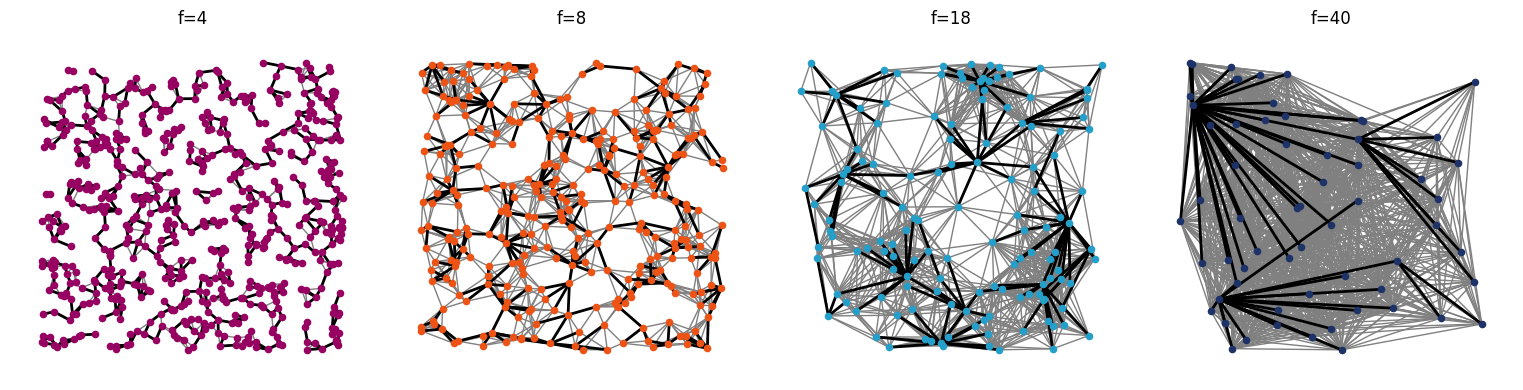

In [300]:
col_map = ['#960162','#ED5315','#249FCA','#1D3367']
# Plot the graph
fig,axs = plt.subplots(1,4,figsize=(11.5/3*4,1*4))
axs = np.reshape(axs,-1)
for f in range(len(Gs)):
    nx.draw_networkx(Gs[f], pos=Ps[f], with_labels=False, ax=axs[f],
                 node_size=20, node_color=col_map[f], width=1, edge_color="grey")
    nx.draw_networkx(Ts[f], pos=Ps[f], with_labels=False, ax=axs[f],
                 node_size=0, node_color=col_map[f], width=2, edge_color="black")
    axs[f].set_title(f"f={fs[f]}")
    axs[f].set_frame_on(False)
    plt.tight_layout()

plt.savefig("/mnt/c/Users/jg9zk/Desktop/Grad/Papers/norbornene homopolymerization/network_sim/f_networks.pdf", format="pdf", bbox_inches="tight")

In [242]:
Ps2 = [nx.spring_layout(g,pos=p,k=1/np.sqrt(g.number_of_nodes()),iterations=100) for g,p in zip(Gs,Ps)]

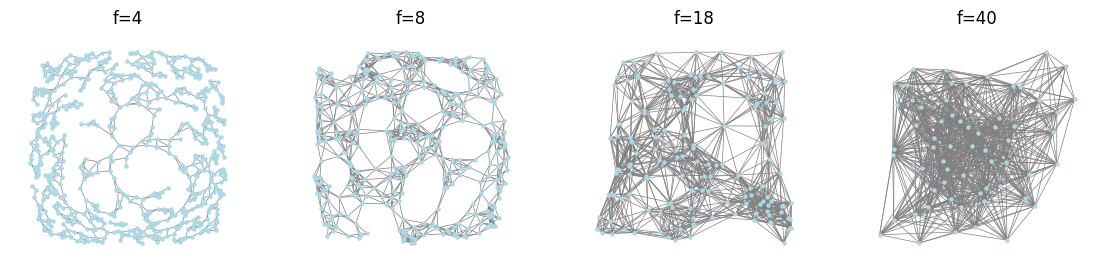

In [238]:
# Plot the graph
fig,axs = plt.subplots(1,4,figsize=(14,3))
axs = np.reshape(axs,-1)
for f in range(len(Gs)):
    nx.draw_networkx(Gs[f], pos=Ps2[f], with_labels=False, ax=axs[f],
                 node_size=5, node_color="lightblue", width=0.5, edge_color="gray")
    axs[f].set_title(f"f={fs[f]}")
    axs[f].set_frame_on(False)

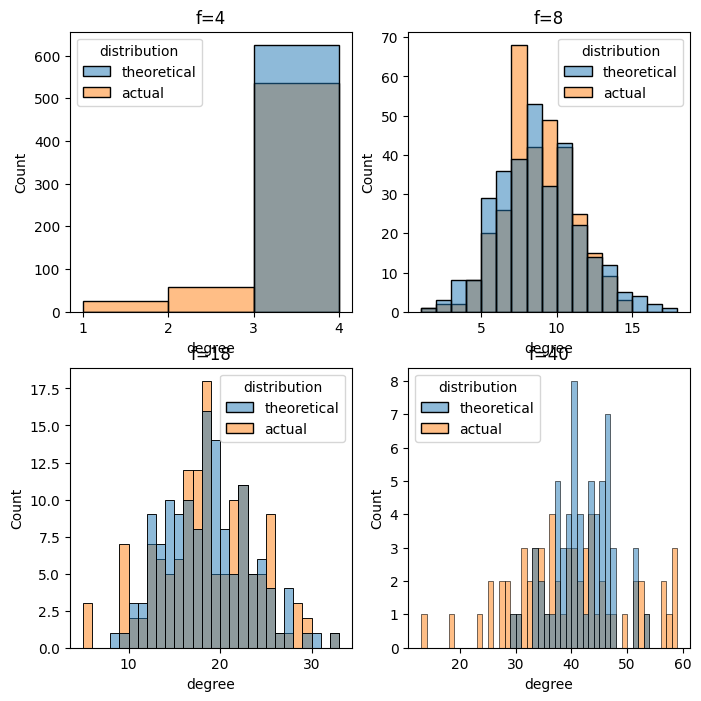

In [301]:
# Plot the graph
fig,axs = plt.subplots(2,2,figsize=(8,8))
axs = np.reshape(axs,-1)
for f in range(len(Gs)):
    actual_k = [d for n, d in Gs[f].degree()]
    degree_df = pd.DataFrame([list(ks[f]) + actual_k,
                              ['theoretical' for x in range(len(ks[f]))] + ['actual' for x in range(len(actual_k))]],
                            index=['degree','distribution']).T
    sns.histplot(degree_df,x='degree',hue='distribution',binwidth=1,ax=axs[f])
    axs[f].set_title(f"f={fs[f]}")

plt.savefig("/mnt/c/Users/jg9zk/Desktop/Grad/Papers/norbornene homopolymerization/network_sim/f_networks_degree_dist.pdf", format="pdf", bbox_inches="tight")

In [643]:
n_norbornene = 2500
fs = [4, 8, 18, 40]
n_nodes = [int(x) for x in n_norbornene/np.array(fs)]
ks = [[fs[0] for x in range(n_nodes[0])], np.random.poisson(fs[1],n_nodes[1]), 
      np.random.poisson(fs[2],n_nodes[2]), np.random.poisson(fs[3],n_nodes[3])]
dists = ['uniform','poisson','poisson','poisson']
radii = [.08, .16, .32, 0.64]#to simulate increasing length of polymers

In [651]:
Gs = []
Ps = []
Ts = []
for i in range(len(n_nodes)):
    # Create the graph
    G, positions = create_k_nearest_neighbors_graph(n_nodes[i], ks[i], radius=radii[i])
    G_pruned = prune_edges_to_x_degree(G, ks[i], dists[i])
    T = nx.minimum_spanning_tree(G_pruned)
    
    Ps.append(positions)
    Gs.append(G_pruned)
    Ts.append(T)

/tmp/ipykernel_203112/1702543536.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  edges_to_remove = random.sample(G.edges(), int(np.diff([sum(k), sum(actual_k)])/2))
/tmp/ipykernel_203112/1702543536.py:28: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  edges_to_remove = random.sample(G.edges(), int(np.diff([sum(k), sum(actual_k)])/2))


In [652]:
[nx.is_connected(g) for g in Gs]

[True, True, True, True]

In [653]:
n_orig_edges = [g.number_of_edges() for g in Gs]
n_orig_edges

[1105, 1232, 1268, 1258]

In [654]:
#n_steps = 1000
#n_edges = [int(np.floor(g.number_of_edges()/n_steps)) for g in Gs]

n_components = []
mean_component_size = []
med_component_size = []


for g,n in zip(Gs,n_orig_edges):
    each_n_components = []
    each_mean_component_size = []
    each_med_component_size = []
    
    for i in range(n):
        g.remove_edges_from(random.sample(g.edges(),1))
        comps = [len(c) for c in sorted(nx.connected_components(g), key=len, reverse=True)]
        each_n_components.append(len(comps))
        each_mean_component_size.append(np.mean(comps))
        each_med_component_size.append(np.median(comps))
        
    n_components.append(each_n_components)
    mean_component_size.append(each_mean_component_size)
    med_component_size.append(each_med_component_size)

/tmp/ipykernel_203112/2188807162.py:15: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  g.remove_edges_from(random.sample(g.edges(),1))


In [655]:
n_orig_edges

[1105, 1232, 1268, 1258]

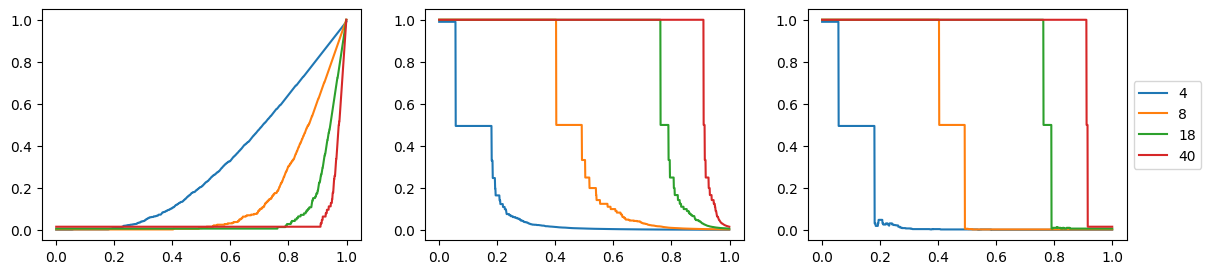

In [658]:
# Plot the graph
fig,axs = plt.subplots(1,3,figsize=(14,3))
axs = np.reshape(axs,-1)

for p,n in zip(n_components,n_nodes):
    axs[0].plot(np.arange(len(p))/len(p),np.array(p)/n)

for p,n in zip(mean_component_size,n_nodes):
    axs[1].plot(np.arange(len(p))/len(p),np.array(p)/n)

for p,n in zip(med_component_size,n_nodes):
    axs[2].plot(np.arange(len(p))/len(p),np.array(p)/n)

plt.legend(['4','8','18','40'],loc='center left', bbox_to_anchor=(1, 0.5))

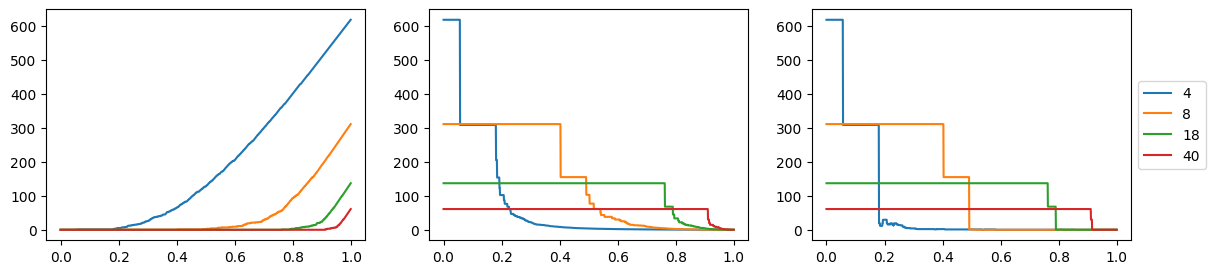

In [659]:
# Plot the graph
fig,axs = plt.subplots(1,3,figsize=(14,3))
axs = np.reshape(axs,-1)

for p,n in zip(n_components,n_nodes):
    axs[0].plot(np.arange(len(p))/len(p),np.array(p))

for p,n in zip(mean_component_size,n_nodes):
    axs[1].plot(np.arange(len(p))/len(p),np.array(p))

for p,n in zip(med_component_size,n_nodes):
    axs[2].plot(np.arange(len(p))/len(p),np.array(p))

plt.legend(['4','8','18','40'],loc='center left', bbox_to_anchor=(1, 0.5))

In [615]:
Gs = []
Ps = []
Ts = []
for i in range(len(n_nodes)):
    # Create the graph
    G, positions = create_k_nearest_neighbors_graph(n_nodes[i], ks[i], radius=radii[i])
    G_pruned = prune_edges_to_x_degree(G, ks[i], dists[i])
    T = nx.minimum_spanning_tree(G_pruned)
    
    Ps.append(positions)
    Gs.append(G_pruned)
    Ts.append(T)

/tmp/ipykernel_203112/1702543536.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  edges_to_remove = random.sample(G.edges(), int(np.diff([sum(k), sum(actual_k)])/2))
/tmp/ipykernel_203112/1702543536.py:28: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  edges_to_remove = random.sample(G.edges(), int(np.diff([sum(k), sum(actual_k)])/2))


In [612]:
n_orig_edges = [g.number_of_edges() for g in Gs]
[g.remove_edges_from(random.sample(g.edges(),int(n*.7))) for g,n in zip(Gs,n_orig_edges)]
n_orig_edges

/tmp/ipykernel_203112/3099374529.py:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  [g.remove_edges_from(random.sample(g.edges(),int(n*.7))) for g,n in zip(Gs,n_orig_edges)]


[446, 486, 495, 478]

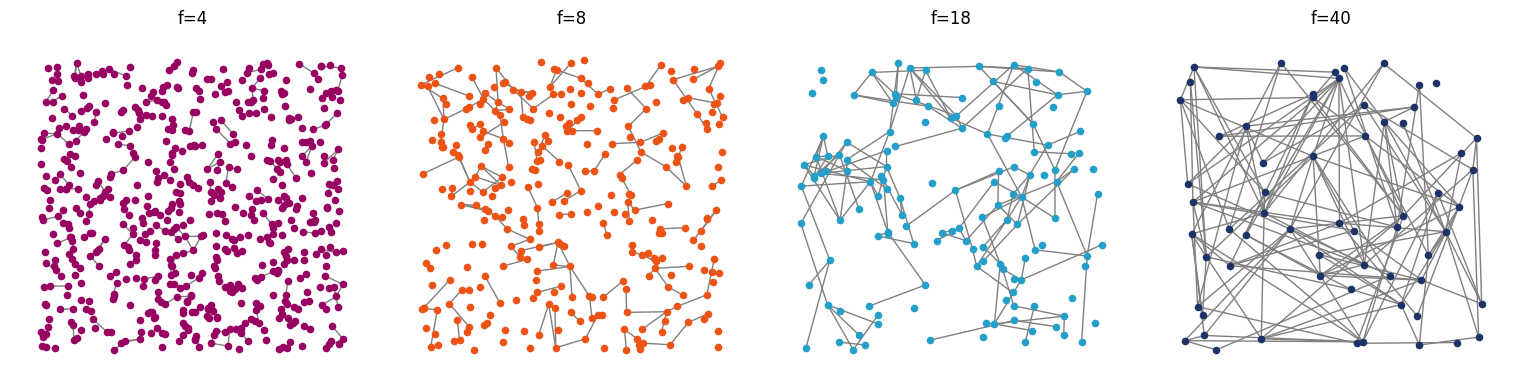

In [613]:
col_map = ['#960162','#ED5315','#249FCA','#1D3367']
# Plot the graph
fig,axs = plt.subplots(1,4,figsize=(11.5/3*4,1*4))
axs = np.reshape(axs,-1)
for f in range(len(Gs)):
    nx.draw_networkx(Gs[f], pos=Ps[f], with_labels=False, ax=axs[f],
                 node_size=20, node_color=col_map[f], width=1, edge_color="grey")
    axs[f].set_title(f"f={fs[f]}")
    axs[f].set_frame_on(False)
    plt.tight_layout()

#plt.savefig("/mnt/c/Users/jg9zk/Desktop/Grad/Papers/norbornene homopolymerization/network_sim/f_networks.pdf", format="pdf", bbox_inches="tight")

In [639]:
Gs = []
Ps = []
Ts = []
for i in range(len(n_nodes)):
    # Create the graph
    G, positions = create_k_nearest_neighbors_graph(n_nodes[i], ks[i], radius=radii[i])
    G_pruned = prune_edges_to_x_degree(G, ks[i], dists[i])
    T = nx.minimum_spanning_tree(G_pruned)
    
    Ps.append(positions)
    Gs.append(G_pruned)
    Ts.append(T)

/tmp/ipykernel_203112/1702543536.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  edges_to_remove = random.sample(G.edges(), int(np.diff([sum(k), sum(actual_k)])/2))
/tmp/ipykernel_203112/1702543536.py:28: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  edges_to_remove = random.sample(G.edges(), int(np.diff([sum(k), sum(actual_k)])/2))


/tmp/ipykernel_203112/3332534666.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  [g.remove_edges_from(random.sample(g.edges(),int(n*.1))) for g,n in zip(Gs,n_orig_edges)]


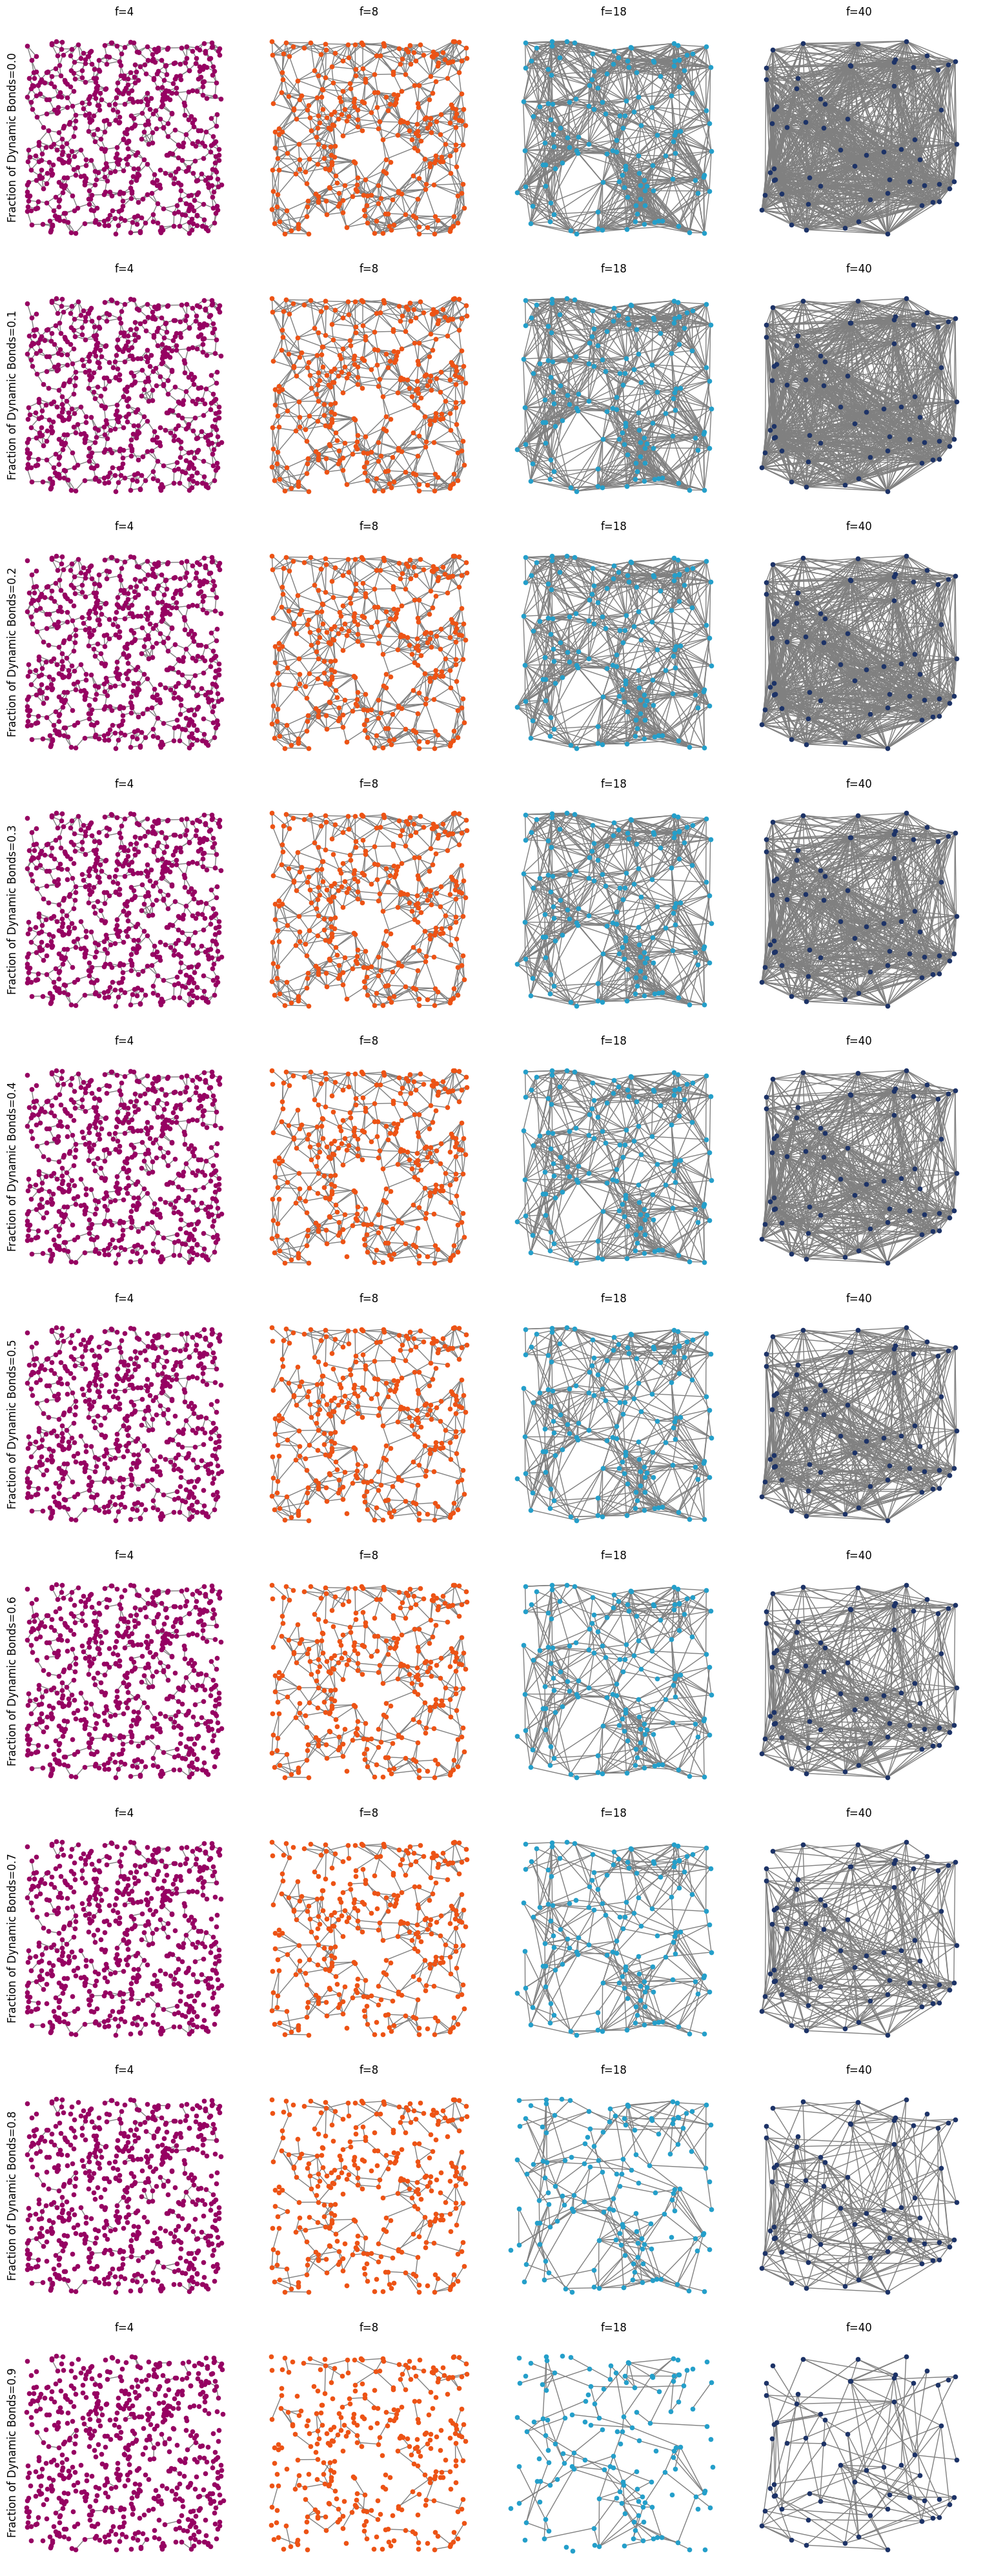

In [640]:
col_map = ['#960162','#ED5315','#249FCA','#1D3367']
# Plot the graph
fig,axs = plt.subplots(10,4,figsize=(11.5/3*4,1*40))

n_orig_edges = [g.number_of_edges() for g in Gs]


for i in range(10):
    if i > 0:
        [g.remove_edges_from(random.sample(g.edges(),int(n*.1))) for g,n in zip(Gs,n_orig_edges)]
    for f in range(len(Gs)):
        nx.draw_networkx(Gs[f], pos=Ps[f], with_labels=False, ax=axs[i,f],
                     node_size=20, node_color=col_map[f], width=1, edge_color="grey")
        axs[i,f].set_title(f"f={fs[f]}")
        
        axs[i,f].set_frame_on(False)
        plt.tight_layout()

    axs[i,0].text(-0.1,0.5,f"Fraction of Dynamic Bonds={np.round(0.1*i,decimals=1)}", size=12, verticalalignment='center', rotation=90)
    

plt.savefig("/mnt/c/Users/jg9zk/Desktop/Grad/Papers/norbornene homopolymerization/network_sim/f_network_degradation.pdf", format="pdf", bbox_inches="tight")

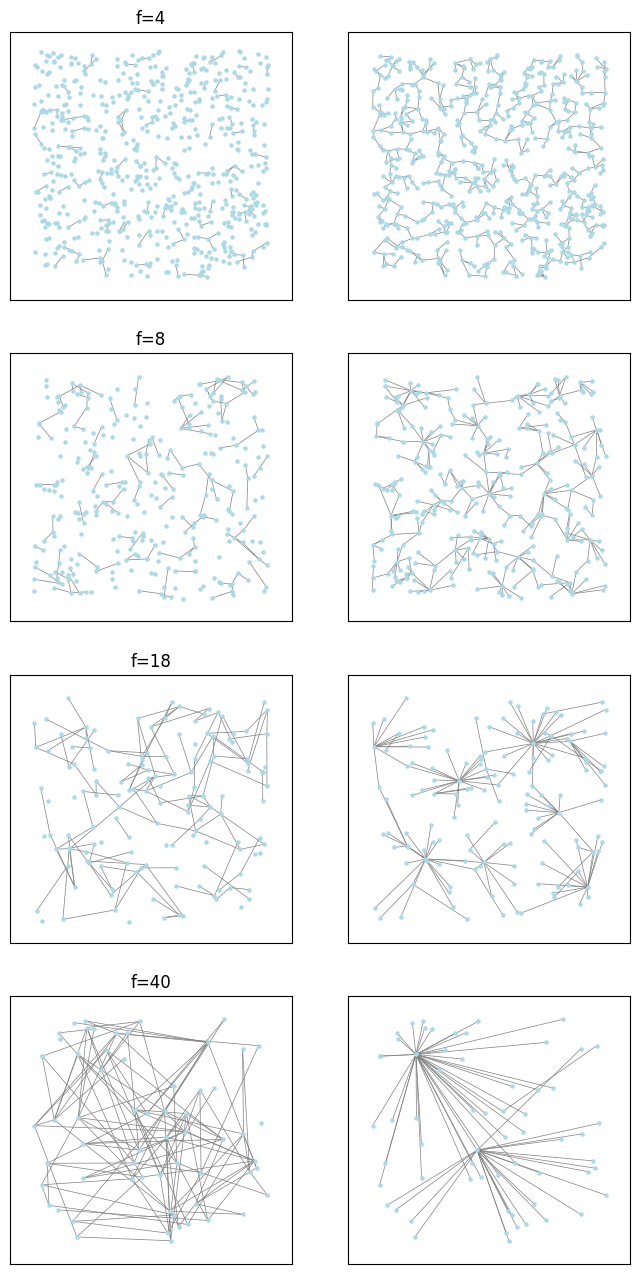

In [637]:
# Plot the graph
fig,axs = plt.subplots(4,2,figsize=(8,16))
#axs = np.reshape(axs,-1)
for f in range(len(Gs)):
    nx.draw_networkx(Gs[f], pos=Ps[f], with_labels=False, ax=axs[f,0],
                 node_size=5, node_color="lightblue", width=0.5, edge_color="gray")
    nx.draw_networkx(Ts[f], pos=Ps[f], with_labels=False, ax=axs[f,1],
                 node_size=5, node_color="lightblue", width=0.5, edge_color="gray")
    axs[f,0].set_title(f"f={fs[f]}")

In [77]:
n_norbornene = 2500
fs = np.arange(1,40)
n_nodes = [int(x) for x in n_norbornene/np.array(fs)]
ks = [np.random.poisson(fs[x],n_nodes[x]) for x in range(len(fs))]
ks = [[fs[y] for x in range(n_nodes[y])] for y in range(len(fs))]
dists = ['uniform' for x in range(len(fs))]
radii = (fs+1)*.03# 1.03, .06, .12, 0.24]#to simulate increasing length of polymers

In [78]:
Gs = []
Ps = []
Ts = []

for i in range(len(n_nodes)):
    # Create the graph
    G, positions = create_k_nearest_neighbors_graph3d(n_nodes[i], ks[i], polym='step', radius=1)#radii[i])
    G_pruned = prune_edges_to_x_degree(G, ks[i], dists[i])
    T = nx.minimum_spanning_tree(G_pruned)
    Ps.append(positions)
    Gs.append(G_pruned)
    Ts.append(T)
    if (i%10==0):
        print(i)

0
10
20
30


In [79]:
pc_step = [t.number_of_edges()/g.number_of_edges() for t,g in zip(Ts,Gs)]
pc_flory = 2/fs#1/(fs-1)

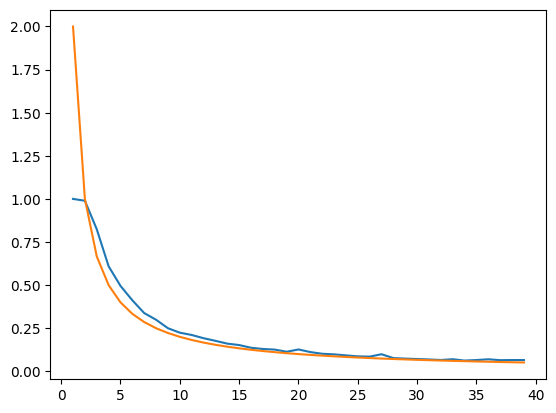

In [80]:
plt.plot(fs,[p/1 for p in pc_step])
plt.plot(fs,pc_flory)

In [261]:
n_norbornene = 10000
fs = np.arange(1,40)
n_nodes = [int(x) for x in n_norbornene/np.array(fs)]
ks = [np.random.poisson(fs[x],n_nodes[x]) for x in range(len(fs))]
dists = ['poisson' for x in range(len(fs))]
radii = (fs+1)*.03# 1.03, .06, .12, 0.24]#to simulate increasing length of polymers

In [262]:
Gs = []
Ps = []
Ts = []

for i in range(len(n_nodes)):
    # Create the graph
    G, positions = create_k_nearest_neighbors_graph(n_nodes[i], ks[i], radius=radii[i], polym='chain')
    G_pruned = prune_edges_to_x_degree(G, ks[i], dists[i])
    T = nx.minimum_spanning_tree(G_pruned)
    Ps.append(positions)
    Gs.append(G_pruned)
    Ts.append(T)
    if (i%10==0):
        print(i)

/tmp/ipykernel_203112/1373745447.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  edges_to_remove = random.sample(G.edges(), int(np.diff([sum(k), sum(actual_k)])/2))
/tmp/ipykernel_203112/1373745447.py:28: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  edges_to_remove = random.sample(G.edges(), int(np.diff([sum(k), sum(actual_k)])/2))


0
10
20
30


In [263]:
pc_chain = [t.number_of_edges()/g.number_of_edges() for t,g in zip(Ts,Gs)]
pc_carothers = 2/fs

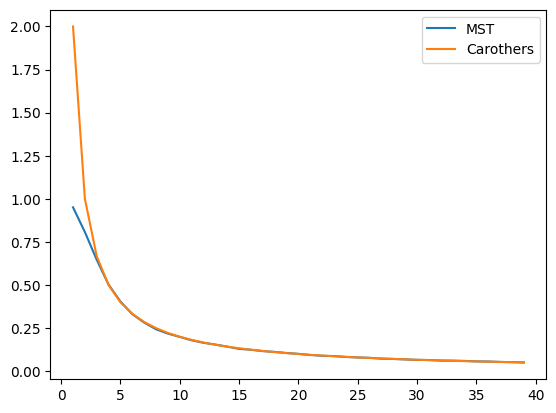

In [265]:
plt.plot(fs,pc_chain)
plt.plot(fs,pc_carothers)
plt.legend(['MST','Carothers'])

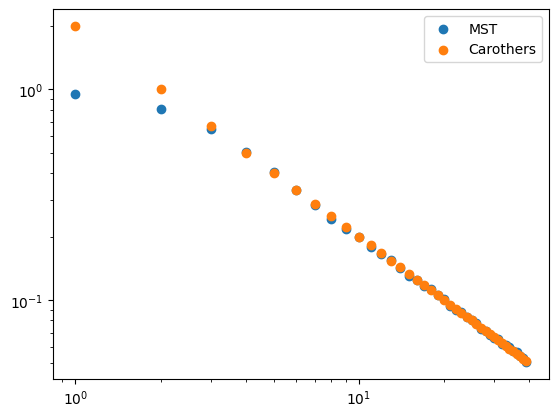

In [282]:
plt.scatter(fs,pc_chain)
plt.scatter(fs,pc_carothers)
plt.legend(['MST','Carothers'])
plt.yscale('log')
plt.xscale('log')

In [284]:
pd.DataFrame([fs,pc_chain,pc_carothers],index=['f','MST','Carothers']).T.to_csv("/mnt/c/Users/jg9zk/Desktop/Grad/Papers/norbornene homopolymerization/network_sim/f_carothers_vs_mst.csv")

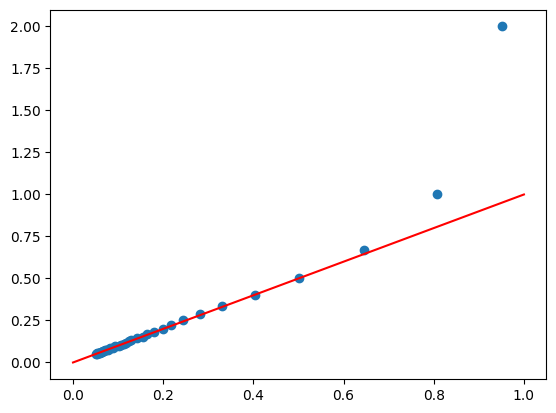

In [272]:
plt.scatter(pc_chain,pc_carothers)
plt.plot([0,1],[0,1],'red')

/tmp/ipykernel_203112/3274883827.py:1: RuntimeWarning: divide by zero encountered in scalar divide
  plt.plot(fs,[1/np.sqrt(f-1) for f in fs])


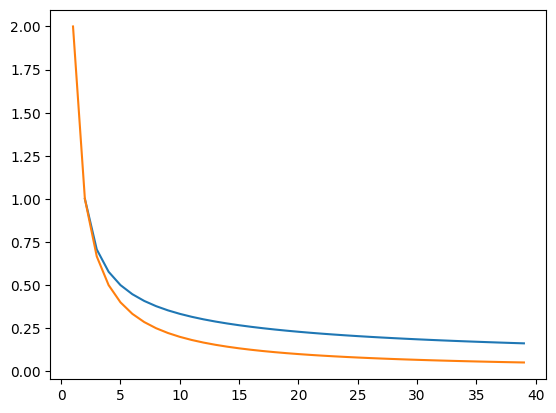

In [276]:
plt.plot(fs,[1/np.sqrt(f-1) for f in fs])
plt.plot(fs,pc_carothers)

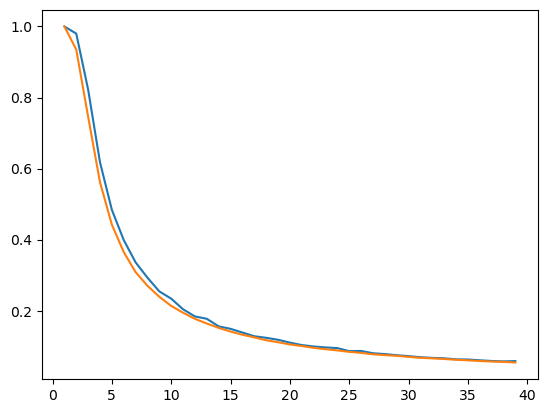

In [216]:
plt.plot(fs,[p/1 for p in pc_step])
plt.plot(fs,[p/1 for p in pc_chain])

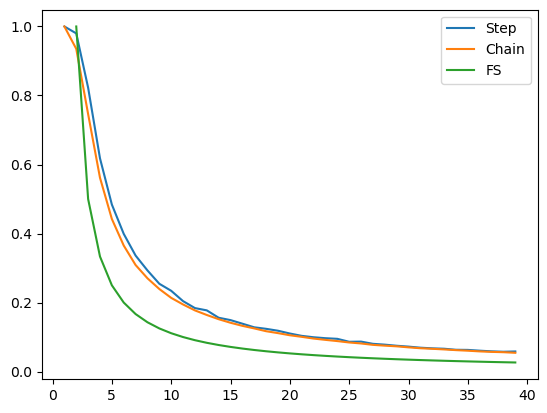

In [224]:
plt.plot(fs,[p/1 for p in pc_step])
plt.plot(fs,[p/1 for p in pc_chain])
plt.plot(fs,pc_flory)
plt.legend(['Step','Chain','FS'])

In [64]:
plt.plot(fs,[p/1 for p in pc_step])
plt.plot(fs,[p/1 for p in pc_chain])
plt.plot(fs,pc_flory)
plt.legend(['Step','Chain','FS'])

NameError: name 'pc_step' is not defined

In [220]:
[s/c for c,s in zip(pc_chain,pc_step)]

[1.0,
 1.0479183451270113,
 1.1025427264647811,
 1.1001074246266556,
 1.0943608631098665,
 1.092755273293476,
 1.088816840438674,
 1.084232754575317,
 1.06348842539537,
 1.0960637300843488,
 1.0496740840638346,
 1.0378067654211807,
 1.0815054259986145,
 1.027777777777778,
 1.0544843049327353,
 1.0471320586927522,
 1.0255570117955437,
 1.059244355019003,
 1.0622041920216363,
 1.0481661511268228,
 1.0278745644599303,
 1.0394996708360764,
 1.0524670685420852,
 1.0740571428571428,
 1.0240051903114187,
 1.0657298277425205,
 1.0387799564270153,
 1.0387817703768625,
 1.0231188658669574,
 1.0300391815411405,
 1.0232758620689657,
 1.019688446559931,
 1.030880420499343,
 1.016810344827586,
 1.0384530386740332,
 1.0352915387987724,
 1.0270093661511652,
 1.023444347063979,
 1.0717550274223033]